In [85]:
import gym
import random, math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
from scripts.reinforce_rwd2go import rollout, make_pref_dataset
from scripts.utils import pref_save, pref_load
from scripts.utils import plot_loss_rewards


from scripts.model import getPolicy
import pickle

import torch
import torch.nn.functional as F
import copy


%load_ext autoreload
%autoreload 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [86]:
SEED=0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

ENV_NAME = 'CartPole-v0'

env = gym.make(ENV_NAME)

K = 1000

POLICY1_NAME = "policies/policy1.pth"
POLICY2_NAME = "policies/policy2_with_mean.pth"
pref_data = pref_load(f"pref_data/pref_data_{K}_{ENV_NAME}.pickle")

/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/guillaumevitalis/miniconda3/envs/RLA2Final/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Epoch:  1
0.6931537985801697
Epoch:  2
0.5590083599090576
Epoch:  3
0.4516964852809906
Epoch:  4
0.3689853250980377
Epoch:  5
0.3074030876159668


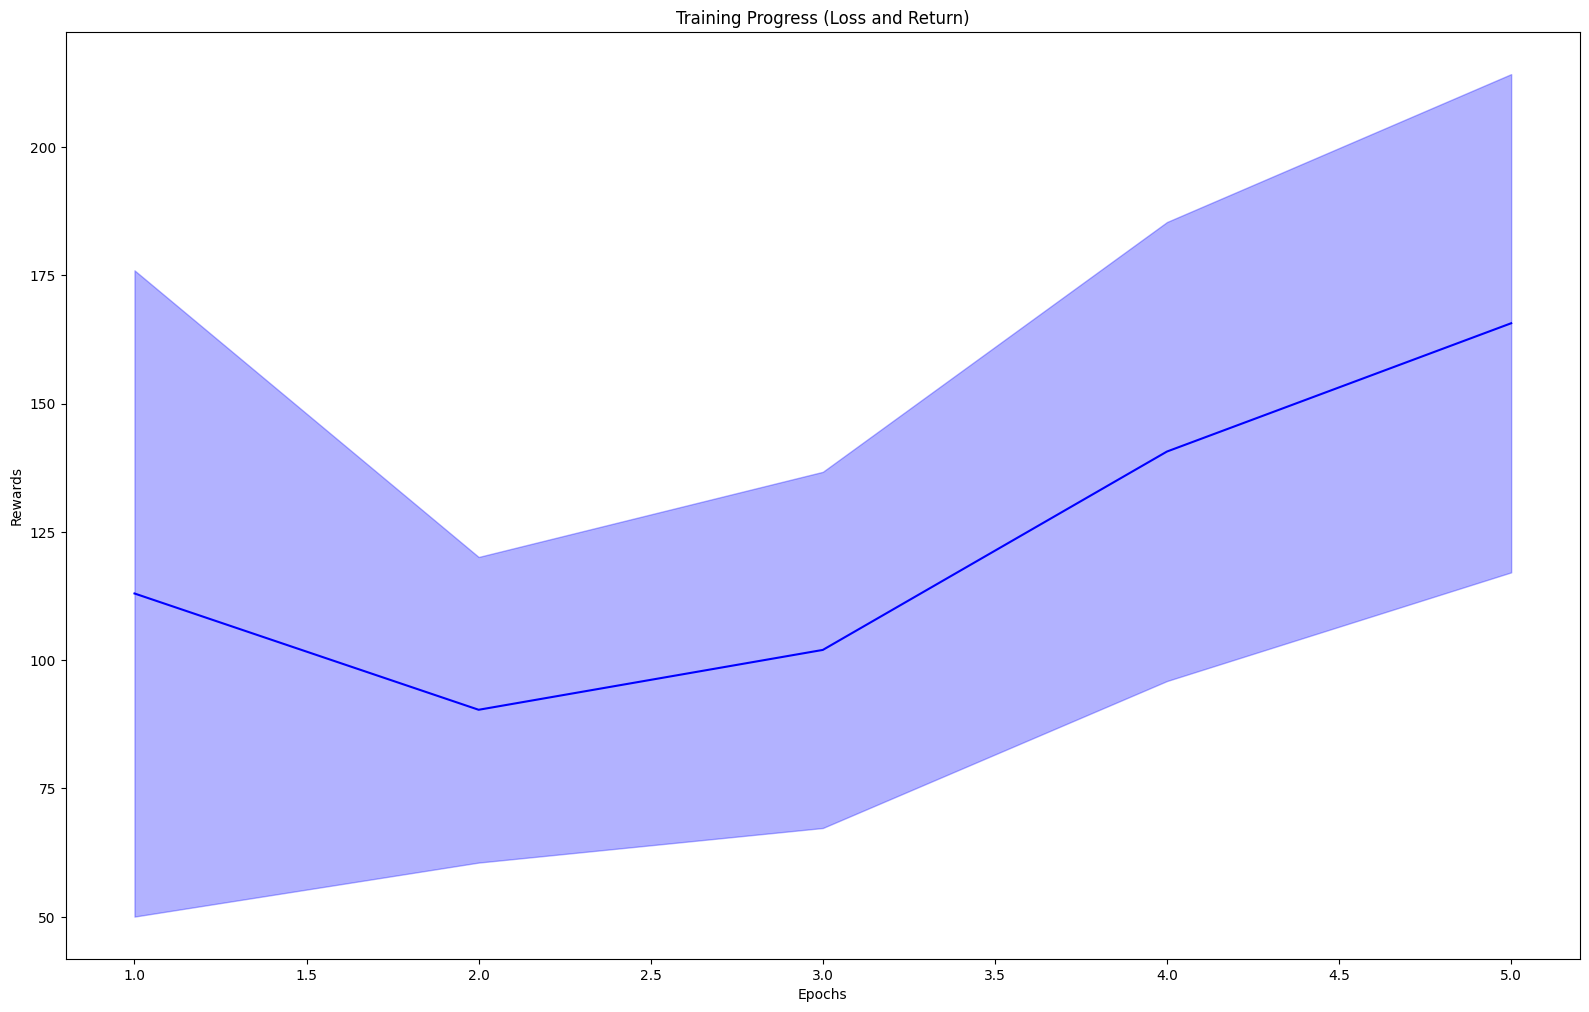

In [ ]:
beta      = 0.5
lr        = 3e-3
#maybe we can have diff plots for diff betas and diff lr to see how they change things?
epochs    = 10

def trajectory_logprob(pi, states, actions):
    logp = torch.tensor(0., device=device)
    for s, a in zip(states, actions):
        s_t = torch.tensor(s, dtype=torch.float32, device=device)
        probs = pi(s_t.unsqueeze(0)).squeeze(0)      # shape [action_dim]
        logp += torch.log(probs[a])
    return logp

def copyPolicy(policy):
    pi_ref = copy.deepcopy(policy).to(device)

    for p in pi_ref.parameters():
        p.requires_grad = False

    return pi_ref


policy1 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy1.load_state_dict(torch.load(POLICY1_NAME))

policy2 = getPolicy(ENV_NAME=ENV_NAME).to(device)
policy2.load_state_dict(torch.load(POLICY2_NAME))

policy = copy.deepcopy(policy2).to(device)
pi_ref = copyPolicy(policy)
optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

losses = []
mean_returns = []
std_returns = []

random.seed(42)

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)

    total_loss = 0.0
    
    for s0, tau_plus, tau_minus in pref_data:
        logp_pos = trajectory_logprob(policy, tau_plus["states"], tau_plus["actions"])
        logp_neg = trajectory_logprob(policy, tau_minus["states"], tau_minus["actions"])
        logp_ref_pos = trajectory_logprob(pi_ref, tau_plus["states"], tau_plus["actions"])
        logp_ref_neg = trajectory_logprob(pi_ref, tau_minus["states"], tau_minus["actions"])

        diff = beta * (logp_pos - logp_ref_pos) - beta * (logp_neg - logp_ref_neg)
        total_loss += -F.logsigmoid(diff)
    
    total_loss = total_loss / len(pref_data)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    loss_value = total_loss.detach().numpy().item()
    losses.append(loss_value)
    print(loss_value)
    
    returns = []
    for _ in range(3):
        seed = random.randint(0, 100000)
        state, done, total_r = env.reset(seed=seed), False, 0.0
        while not done:
            with torch.no_grad():
                action, _ = policy.act(state)
            state, r, done, _ = env.step(action)
            total_r += r
        returns.append(total_r)

    returns = np.array(returns)
    mean_returns.append(returns.mean())
    std_returns.append(returns.std())

mean_returns = np.array(mean_returns)
std_returns = np.array(std_returns)

x = list(range(1, epochs + 1))
plot_loss_rewards(x, losses, mean_returns, std_returns, title="Training Progress (Loss and Return)")